#Encoding Videos using ConvLSTM Autoencoder

### Importing libraries

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, save_model
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, MaxPooling3D, Flatten, Dense, MaxPool3D
from tensorflow.keras.layers import Reshape, UpSampling3D, Input, TimeDistributed
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam, RMSprop, Adagrad
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = "/content/drive/MyDrive/Dissertation/Unsupervised Learning from Videos/Dataset/"

### Loading and Preprocessing the video

In [ ]:
no_of_frames = 250
frame_height = 16
frame_width = 16
channels = 3

In [ ]:
# reading the video frame by frame
def get_frames(video_path):
  frame_list = []
  count = 1

  # capturing the video using opencv
  video = cv2.VideoCapture(video_path)

  # looping till the no_of_frames are extracted
  while count <= no_of_frames:

    # read each frame from a video
    success, frame = video.read()

    # on success of reading a frame resize and normalize the frame and append to the list
    if success:
      frame = cv2.resize(frame, (frame_height, frame_width))
      frame = frame.astype('float32') / 255.0
      frame_list.append(frame)
      count+=1
    else:
      break
      
  return frame_list

In [ ]:
# Preparing the dataset of videos with each of 250 frames of 16x16x3 size
X_train = []
X_test = []
y_train = []
y_test = []
str_class = 'dance'

# listing the directories under dataset_path
subdirs = os.listdir(dataset_path) # includes train and test folders

for folders in subdirs:
  # listing the directories under train and test folders
  train_test = os.listdir(os.path.join(dataset_path, folders)) # includes dance and fight folders

  for train_test_data in train_test:
    # listing the files under dance and fight folders
    video_files = os.listdir(os.path.join(os.path.join(dataset_path, folders), train_test_data))

    for vid in video_files:
      # iterating through each video file and getting the frame list
      frames =  get_frames(os.path.join(os.path.join(os.path.join(dataset_path, folders), train_test_data), vid))
      #print(vid, "  --  ", np.asarray(frames).shape)

      if len(frames) == no_of_frames:
        # check if the folder is train then add the data to the train list
        if folders.lower() == 'train':
          X_train.append(frames)

          # preparing the target variable based on dance and fight category - dance : 0 , fight : 1
          if train_test_data.lower() == str_class.lower():
            y_train.append(0)
          else:
            y_train.append(1)
        # check if the folder is test then add the data to the test list
        elif folders.lower() == 'test':
          X_test.append(frames)

          if train_test_data.lower() == str_class.lower():
            y_test.append(0)
          else:
            y_test.append(1)

In [ ]:
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
X_train.shape, X_test.shape

((48, 250, 16, 16, 3), (12, 250, 16, 16, 3))

In [ ]:
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
y_train.shape, y_test.shape

((48,), (12,))

In [ ]:
print("y_train", y_train , "\n")
print("y_test", y_test)

y_train [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0] 

y_test [0 0 0 0 0 0 1 1 1 1 1 1]


### Building ConvLSTM Encoder Decoder

In [ ]:
autoencoder = Sequential()

# Encoder
autoencoder.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), padding="same", return_sequences=True, 
                      dropout=0.1, recurrent_dropout=0.1, input_shape=(no_of_frames, frame_width, frame_height, channels)))
autoencoder.add(MaxPool3D(pool_size=(1, 2, 2), strides=(1, 2, 2), padding="same"))
autoencoder.add(BatchNormalization())
           
autoencoder.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), padding="same", return_sequences=True, 
                      dropout=0.1, recurrent_dropout=0.1))
autoencoder.add(MaxPool3D(pool_size=(1, 2, 2), strides=(1, 2, 2), padding="same"))
autoencoder.add(BatchNormalization())
           
autoencoder.add(Flatten())

# Decoder
flatten_output_shape = autoencoder.layers[5].output.shape
reshape_dim = (flatten_output_shape[1], flatten_output_shape[2], flatten_output_shape[3], flatten_output_shape[4])

autoencoder.add(Reshape(reshape_dim))

autoencoder.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), padding="same", return_sequences=True, 
                      dropout=0.1, recurrent_dropout=0.1))
autoencoder.add(UpSampling3D(size=(1, 2, 2)))

autoencoder.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), padding="same", return_sequences=True, 
                      dropout=0.1, recurrent_dropout=0.1))
autoencoder.add(UpSampling3D(size=(1, 2, 2)))

autoencoder.add(ConvLSTM2D(filters=3, kernel_size=(3, 3), padding="same", return_sequences=True, 
                      dropout=0.1, recurrent_dropout=0.1))

autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 250, 16, 16, 32)   40448     
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 250, 8, 8, 32)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 250, 8, 8, 32)     128       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 250, 8, 8, 16)     27712     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 250, 4, 4, 16)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 250, 4, 4, 16)     64        
_________________________________________________________________
flatten (Flatten)            (None, 64000)             0

#### Plotting the Autoencoder model

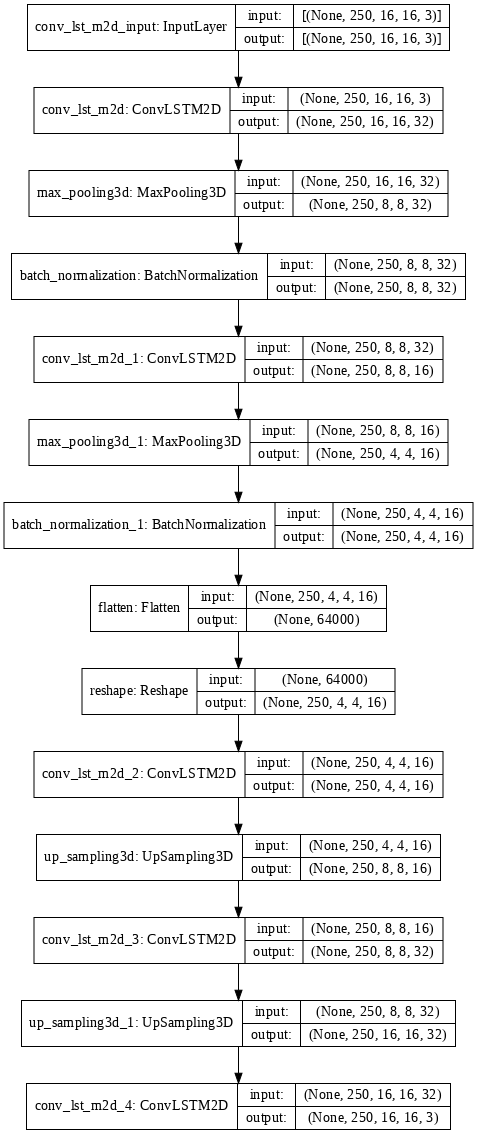

In [ ]:
tf.keras.utils.plot_model(
    autoencoder,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=72,
)

## Comparison based on Optimizers

### Optimizer 1 - RMSprop

In [ ]:
# creating a compiler for the model
autoencoder_rmsprop = autoencoder
autoencoder_rmsprop.compile(loss='mse', optimizer=RMSprop(learning_rate=0.01), metrics=['accuracy'])

In [ ]:
history_rmsprop = autoencoder_rmsprop.fit(X_train, X_train, epochs=300)

Epoch 1/300


ResourceExhaustedError: ignored

#### Saving the RMSprop model

In [ ]:
model_rmsprop_json = autoencoder_rmsprop.to_json()
with open('RMSprop_model.json', 'w') as json_file:
  json_file.write(model_rmsprop_json)

In [ ]:
rmsprop_model_saved = save_model(autoencoder_rmsprop, '/content/weights_rmsprop.hdf5')

In [ ]:
np.save('RMSprop_history.npy', history_rmsprop.history)

#### Visualizing Loss and Accuracy of model with RMSprop

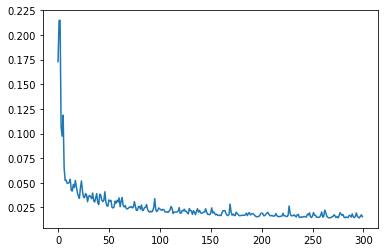

In [ ]:
plt.plot(history_rmsprop.history['loss'])

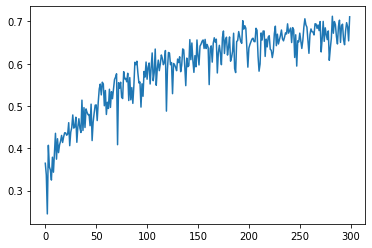

In [ ]:
plt.plot(history_rmsprop.history['accuracy'])

### Optimizer 2 - Adam

In [ ]:
# creating a compiler for the model
autoencoder_adam = autoencoder
autoencoder_adam.compile(loss='mse', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

In [ ]:
history_adam = autoencoder_adam.fit(X_train, X_train, epochs=300)

Epoch 1/300
2/2 [==============================] - 30s 8s/step - loss: 0.1515 - accuracy: 0.3242
Epoch 2/300
2/2 [==============================] - 16s 8s/step - loss: 0.1457 - accuracy: 0.3727
Epoch 3/300
2/2 [==============================] - 16s 8s/step - loss: 0.0749 - accuracy: 0.3509
Epoch 4/300
2/2 [==============================] - 16s 8s/step - loss: 0.0661 - accuracy: 0.4161
Epoch 5/300
2/2 [==============================] - 16s 8s/step - loss: 0.0608 - accuracy: 0.3289
Epoch 6/300
2/2 [==============================] - 16s 8s/step - loss: 0.0488 - accuracy: 0.4176
Epoch 7/300
2/2 [==============================] - 16s 8s/step - loss: 0.0472 - accuracy: 0.4217
Epoch 8/300
2/2 [==============================] - 16s 8s/step - loss: 0.0456 - accuracy: 0.2947
Epoch 9/300
2/2 [==============================] - 16s 8s/step - loss: 0.0427 - accuracy: 0.4385
Epoch 10/300
2/2 [==============================] - 16s 8s/step - loss: 0.0424 - accuracy: 0.4778
Epoch 11/300
2/2 [===========

#### Saving the Adam model

In [ ]:
model_adam_json = autoencoder_adam.to_json()
with open('Adam_model.json', 'w') as json_file:
  json_file.write(model_adam_json)

In [ ]:
adam_model_saved = save_model(autoencoder_adam, '/content/weights_adam.hdf5')

In [ ]:
np.save('Adam_history.npy', history_adam.history)

#### Visualizing Loss and Accuracy of model with Adam optimizer

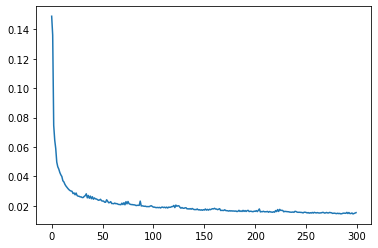

In [ ]:
plt.plot(history_adam.history['loss'])

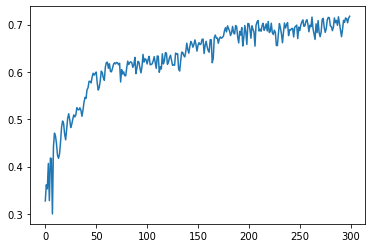

In [ ]:
plt.plot(history_adam.history['accuracy'])

### Optimizer 3 - Adagrad

In [ ]:
# creating a compiler for the model
autoencoder_adagrad = autoencoder
autoencoder_adagrad.compile(loss='mse', optimizer=Adagrad(learning_rate=0.01), metrics=['accuracy'])

In [ ]:
history_adagrad = autoencoder_adagrad.fit(X_train, X_train, epochs=300)

Epoch 1/300
2/2 [==============================] - 30s 8s/step - loss: 0.1411 - accuracy: 0.3771
Epoch 2/300
2/2 [==============================] - 16s 8s/step - loss: 0.1252 - accuracy: 0.3736
Epoch 3/300
2/2 [==============================] - 16s 8s/step - loss: 0.1126 - accuracy: 0.3744
Epoch 4/300
2/2 [==============================] - 16s 8s/step - loss: 0.1014 - accuracy: 0.3727
Epoch 5/300
2/2 [==============================] - 16s 8s/step - loss: 0.0956 - accuracy: 0.3675
Epoch 6/300
2/2 [==============================] - 16s 8s/step - loss: 0.0887 - accuracy: 0.3737
Epoch 7/300
2/2 [==============================] - 16s 8s/step - loss: 0.0832 - accuracy: 0.3840
Epoch 8/300
2/2 [==============================] - 16s 8s/step - loss: 0.0790 - accuracy: 0.3778
Epoch 9/300
2/2 [==============================] - 16s 8s/step - loss: 0.0755 - accuracy: 0.3817
Epoch 10/300
2/2 [==============================] - 16s 8s/step - loss: 0.0736 - accuracy: 0.3796
Epoch 11/300
2/2 [===========

#### Saving the Adagrad model

In [ ]:
model_adagrad_json = autoencoder_adagrad.to_json()
with open('Adagrad_model.json', 'w') as json_file:
  json_file.write(model_adagrad_json)

In [ ]:
adagrad_model_saved = save_model(autoencoder_adagrad, '/content/weights_adagrad.hdf5')

In [ ]:
np.save('Adagrad_history.npy', history_adagrad.history)

#### Visualizing Loss and Accuracy of model with Adagrad optimizer

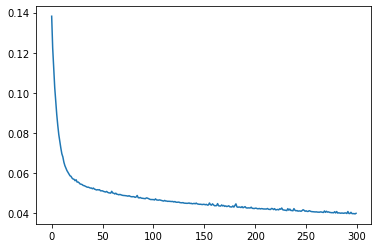

In [ ]:
plt.plot(history_adagrad.history['loss'])

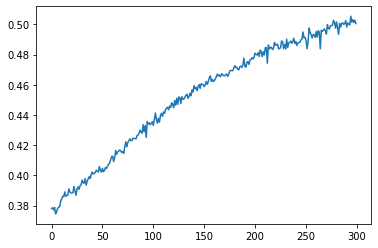

In [ ]:
plt.plot(history_adagrad.history['accuracy'])

## Comparison Report

### Loading all the saved history - RMSprop, Adam and Adagrad

In [ ]:
saved_model_path = "/content/drive/MyDrive/Colab Notebooks/Unsupervised Learning from Videos/saved_model/"

In [ ]:
rmsprop_history = np.load(saved_model_path + 'RMSprop_history.npy',allow_pickle='TRUE').item()
adam_history = np.load(saved_model_path + 'Adam_history.npy',allow_pickle='TRUE').item()
adagrad_history = np.load(saved_model_path + 'Adagrad_history.npy',allow_pickle='TRUE').item()

### Plotting the loss and accuracy of RMSprop, Adam and Adagrad optimizers

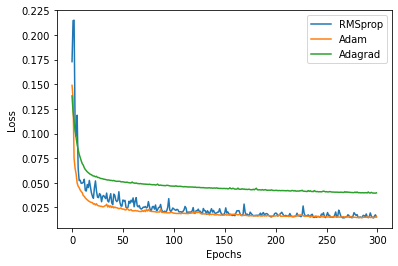

In [ ]:
plt.plot(rmsprop_history['loss'], label='RMSprop')
plt.plot(adam_history['loss'], label='Adam')
plt.plot(adagrad_history['loss'], label='Adagrad')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

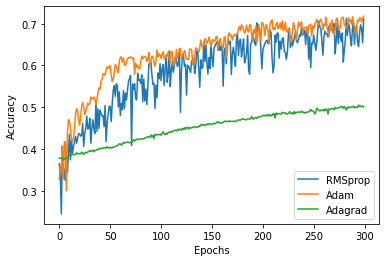

In [ ]:
plt.plot(rmsprop_history['accuracy'], label='RMSprop')
plt.plot(adam_history['accuracy'], label='Adam')
plt.plot(adagrad_history['accuracy'], label='Adagrad')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Comparison based on KMeans Clustering

#### Clustering Analysis based on RMSprop optimizer model

In [ ]:
# reading the model from the json file
with open(saved_model_path + 'RMSprop_model.json', 'r') as json_file:
  rmsprop_json_saved_model = json_file.read()

##### Loading the weights of RMSprop model

In [ ]:
rmsprop_model = tf.keras.models.model_from_json(rmsprop_json_saved_model)
rmsprop_model.load_weights(saved_model_path + 'weights_rmsprop.hdf5')
rmsprop_model.compile(loss='mse', optimizer=RMSprop(learning_rate=0.01), metrics=['accuracy'])

##### Encoder to create representation of Dataset

In [ ]:
# creating an encoder 
encoder_rmsprop = Model(inputs = rmsprop_model.input, outputs = rmsprop_model.layers[6].output)
encoder_rmsprop.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_input (InputLay [(None, 250, 16, 16, 3)]  0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 250, 16, 16, 32)   40448     
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 250, 8, 8, 32)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 250, 8, 8, 32)     128       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 250, 8, 8, 16)     27712     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 250, 4, 4, 16)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 250, 4, 4, 16)     64    

##### Encoding the Test video dataset

In [ ]:
# encoding the Test videos
encoded_test_video_rmsprop = encoder_rmsprop.predict(X_test)
encoded_test_video_rmsprop.shape

(12, 64000)

###### KMeans Clustering using the encoded representation of the Test dataset

In [ ]:
from sklearn.cluster import KMeans

# 2 cluster groups for dance and fight
n_clusters = 2 

kmeans_rmsprop = KMeans(n_clusters=n_clusters, n_init=20)

y_pred_kmeans_rmsprop_test = kmeans_rmsprop.fit_predict(encoded_test_video_rmsprop)
y_pred_kmeans_rmsprop_test

array([0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0], dtype=int32)

###### Evaluating the Clustering algorithm for Test dataset

In [ ]:
from sklearn.metrics import accuracy_score
rmsprop_clustering_accuracy_test = accuracy_score(y_test, y_pred_kmeans_rmsprop_test)
rmsprop_clustering_accuracy_test

0.5833333333333334

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_kmeans_rmsprop_test)
cm

array([[5, 1],
       [4, 2]])

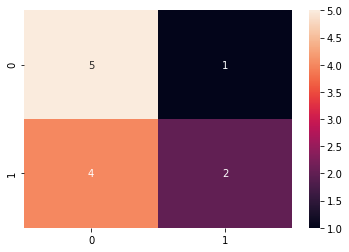

In [ ]:
import seaborn as sns
sns.heatmap(cm, annot=True);

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_kmeans_rmsprop_test))

              precision    recall  f1-score   support

           0       0.56      0.83      0.67         6
           1       0.67      0.33      0.44         6

    accuracy                           0.58        12
   macro avg       0.61      0.58      0.56        12
weighted avg       0.61      0.58      0.56        12



##### Encoding the Train video dataset

In [ ]:
# encoding the Train videos
encoded_train_video_rmsprop = encoder_rmsprop.predict(X_train)
encoded_train_video_rmsprop.shape

(48, 64000)

###### KMeans Clustering using the encoded representation of the Train dataset

In [ ]:
from sklearn.cluster import KMeans

# 2 cluster groups for dance and fight
n_clusters = 2 

kmeans_rmsprop = KMeans(n_clusters=n_clusters, n_init=20)

y_pred_kmeans_rmsprop_train = kmeans_rmsprop.fit_predict(encoded_train_video_rmsprop)
y_pred_kmeans_rmsprop_train

array([0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0], dtype=int32)

###### Evaluating the Clustering algorithm for Train dataset

In [ ]:
from sklearn.metrics import accuracy_score
rmsprop_clustering_accuracy_train = accuracy_score(y_train, y_pred_kmeans_rmsprop_train)
rmsprop_clustering_accuracy_train

0.5416666666666666

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train, y_pred_kmeans_rmsprop_train)
cm

array([[13, 11],
       [11, 13]])

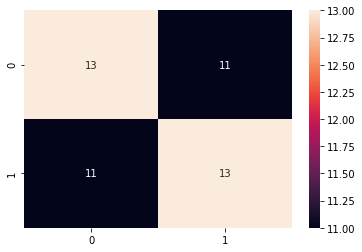

In [ ]:
import seaborn as sns
sns.heatmap(cm, annot=True);

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_train, y_pred_kmeans_rmsprop_train))

              precision    recall  f1-score   support

           0       0.54      0.54      0.54        24
           1       0.54      0.54      0.54        24

    accuracy                           0.54        48
   macro avg       0.54      0.54      0.54        48
weighted avg       0.54      0.54      0.54        48



#### Clustering Analysis based on Adam optimizer model

In [ ]:
# reading the model from the json file
with open(saved_model_path + 'Adam_model.json', 'r') as json_file:
  adam_json_saved_model = json_file.read()


##### Loading the weights of Adam model

In [ ]:
adam_model = tf.keras.models.model_from_json(rmsprop_json_saved_model)
adam_model.load_weights(saved_model_path + 'weights_adam.hdf5')
adam_model.compile(loss='mse', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

##### Encoder to create representation of Dataset

In [ ]:
# creating an encoder 
encoder_adam = Model(inputs = adam_model.input, outputs = adam_model.layers[6].output)
encoder_adam.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_input (InputLay [(None, 250, 16, 16, 3)]  0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 250, 16, 16, 32)   40448     
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 250, 8, 8, 32)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 250, 8, 8, 32)     128       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 250, 8, 8, 16)     27712     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 250, 4, 4, 16)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 250, 4, 4, 16)     64  

##### Encoding the Test video dataset

In [ ]:
# encoding the Test videos
encoded_test_video_adam = encoder_adam.predict(X_test)
encoded_test_video_adam.shape

(12, 64000)

###### KMeans Clustering using the encoded representation of the Test dataset

In [ ]:
from sklearn.cluster import KMeans

# 2 cluster groups for dance and fight
n_clusters = 2 

kmeans_adam = KMeans(n_clusters=n_clusters, n_init=20)

y_pred_kmeans_adam_test = kmeans_adam.fit_predict(encoded_test_video_adam)
y_pred_kmeans_adam_test

array([0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0], dtype=int32)

###### Evaluating the Clustering algorithm for Test dataset

In [ ]:
from sklearn.metrics import accuracy_score
adam_clustering_accuracy_test = accuracy_score(y_test, y_pred_kmeans_adam_test)
adam_clustering_accuracy_test

0.5

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_kmeans_adam_test)
cm

array([[4, 2],
       [4, 2]])

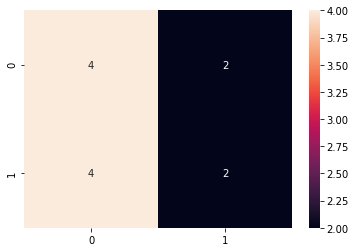

In [ ]:
import seaborn as sns
sns.heatmap(cm, annot=True);

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_kmeans_adam_test))

              precision    recall  f1-score   support

           0       0.50      0.67      0.57         6
           1       0.50      0.33      0.40         6

    accuracy                           0.50        12
   macro avg       0.50      0.50      0.49        12
weighted avg       0.50      0.50      0.49        12



##### Encoding the Train video dataset

In [ ]:
# encoding the Test videos
encoded_train_video_adam = encoder_adam.predict(X_train)
encoded_train_video_adam.shape

(48, 64000)

###### KMeans Clustering using the encoded representation of the Train dataset

In [ ]:
from sklearn.cluster import KMeans

# 2 cluster groups for dance and fight
n_clusters = 2 

kmeans_adam = KMeans(n_clusters=n_clusters, n_init=20)

y_pred_kmeans_adam_train = kmeans_adam.fit_predict(encoded_train_video_adam)
y_pred_kmeans_adam_train

array([0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0], dtype=int32)

###### Evaluating the Clustering algorithm for Train dataset

In [ ]:
from sklearn.metrics import accuracy_score
adam_clustering_accuracy_train = accuracy_score(y_train, y_pred_kmeans_adam_train)
adam_clustering_accuracy_train

0.5208333333333334

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train, y_pred_kmeans_adam_train)
cm

array([[12, 12],
       [11, 13]])

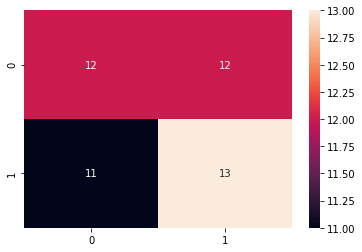

In [ ]:
import seaborn as sns
sns.heatmap(cm, annot=True);

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_train, y_pred_kmeans_adam_train))

              precision    recall  f1-score   support

           0       0.52      0.50      0.51        24
           1       0.52      0.54      0.53        24

    accuracy                           0.52        48
   macro avg       0.52      0.52      0.52        48
weighted avg       0.52      0.52      0.52        48



#### Clustering Analysis based on Adagrad optimizer model

In [ ]:
# reading the model from the json file
with open(saved_model_path + 'Adagrad_model.json', 'r') as json_file:
  adagrad_json_saved_model = json_file.read()

##### Loading the weights of Adagrad model

In [ ]:
adagrad_model = tf.keras.models.model_from_json(rmsprop_json_saved_model)
adagrad_model.load_weights(saved_model_path + 'weights_adagrad.hdf5')
adagrad_model.compile(loss='mse', optimizer=Adagrad(learning_rate=0.01), metrics=['accuracy'])

##### Encoder to create representation of Test Dataset

In [ ]:
# creating an encoder 
encoder_adagrad = Model(inputs = adagrad_model.input, outputs = adagrad_model.layers[6].output)
encoder_adagrad.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_input (InputLay [(None, 250, 16, 16, 3)]  0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 250, 16, 16, 32)   40448     
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 250, 8, 8, 32)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 250, 8, 8, 32)     128       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 250, 8, 8, 16)     27712     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 250, 4, 4, 16)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 250, 4, 4, 16)     64  

##### Encodong the Test video dataset

In [ ]:
# encoding the Test videos
encoded_test_video_adagrad = encoder_adagrad.predict(X_test)
encoded_test_video_adagrad.shape

(12, 64000)

###### KMeans Clustering using the encoded representation of the Test dataset

In [ ]:
from sklearn.cluster import KMeans

# 2 cluster groups for dance and fight
n_clusters = 2 

kmeans_adagrad = KMeans(n_clusters=n_clusters, n_init=20)

y_pred_kmeans_adagrad_test = kmeans_adagrad.fit_predict(encoded_test_video_adagrad)
y_pred_kmeans_adagrad_test

array([0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0], dtype=int32)

###### Evaluating the Clustering algorithm for Test dataset

In [ ]:
from sklearn.metrics import accuracy_score
adagrad_clustering_accuracy_test = accuracy_score(y_test, y_pred_kmeans_adagrad_test)
adagrad_clustering_accuracy_test

0.5833333333333334

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_kmeans_adagrad_test)
cm

array([[4, 2],
       [3, 3]])

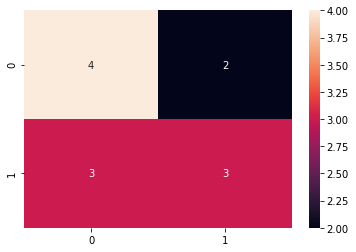

In [ ]:
import seaborn as sns
sns.heatmap(cm, annot=True);

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_kmeans_adagrad_test))

              precision    recall  f1-score   support

           0       0.57      0.67      0.62         6
           1       0.60      0.50      0.55         6

    accuracy                           0.58        12
   macro avg       0.59      0.58      0.58        12
weighted avg       0.59      0.58      0.58        12



##### Encodong the Train video dataset

In [ ]:
# encoding the Test videos
encoded_train_video_adagrad = encoder_adagrad.predict(X_train)
encoded_train_video_adagrad.shape

(48, 64000)

###### KMeans Clustering using the encoded representation of the Train dataset

In [ ]:
from sklearn.cluster import KMeans

# 2 cluster groups for dance and fight
n_clusters = 2 

kmeans_adagrad = KMeans(n_clusters=n_clusters, n_init=20)

y_pred_kmeans_adagrad_train = kmeans_adagrad.fit_predict(encoded_train_video_adagrad)
y_pred_kmeans_adagrad_train

array([1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 1], dtype=int32)

###### Evaluating the Clustering algorithm for Train dataset

In [ ]:
from sklearn.metrics import accuracy_score
adagrad_clustering_accuracy_train = accuracy_score(y_train, y_pred_kmeans_adagrad_train)
adagrad_clustering_accuracy_train

0.5416666666666666

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train, y_pred_kmeans_adagrad_train)
cm

array([[14, 10],
       [12, 12]])

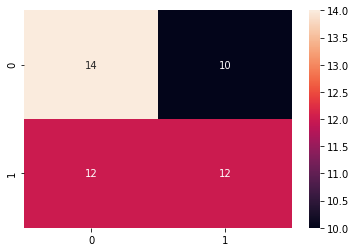

In [ ]:
import seaborn as sns
sns.heatmap(cm, annot=True);

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_train, y_pred_kmeans_adagrad_train))

              precision    recall  f1-score   support

           0       0.54      0.58      0.56        24
           1       0.55      0.50      0.52        24

    accuracy                           0.54        48
   macro avg       0.54      0.54      0.54        48
weighted avg       0.54      0.54      0.54        48



#### Plotting the Comparison of KMeans clustering

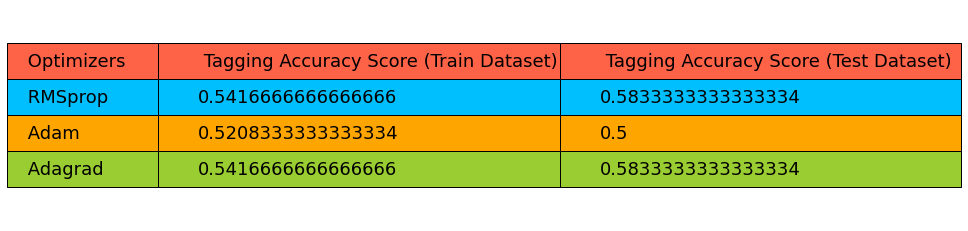

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
data=[[" RMSprop ", rmsprop_clustering_accuracy_train, rmsprop_clustering_accuracy_test],
      [" Adam ", adam_clustering_accuracy_train, adam_clustering_accuracy_test],
      [" Adagrad ", adagrad_clustering_accuracy_train, adagrad_clustering_accuracy_test]]
column_labels=[" Optimizers ", " Tagging Accuracy Score (Train Dataset) ", " Tagging Accuracy Score (Test Dataset) "]
ax.axis('tight')
ax.axis('off')
table = plt.table(cellText = data,
                  colLabels = column_labels,
                  loc = "center", 
                  cellLoc = 'left',
                  colLoc = 'left',
                  colColours = ["tomato"] * 3,
                  cellColours = [["deepskyblue"] * 3, ["orange"] * 3, ["yellowgreen"] * 3],
                  colWidths = [0.15, 0.4, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(18)
table.scale(3, 3)
plt.show()

#### Bar Graph representation of Comparison of Tagging using KMeans Clustering

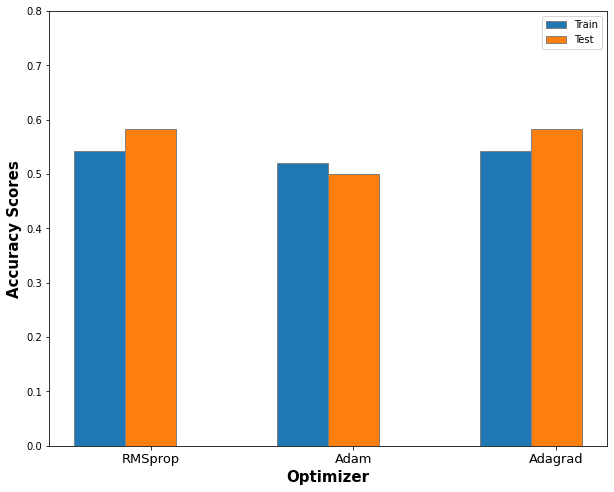

In [ ]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(10, 8))
 
# set height of bar
optimizers = ['RMSprop', 'Adam', 'Adagrad']
Train = [rmsprop_clustering_accuracy_train, adam_clustering_accuracy_train, adagrad_clustering_accuracy_train]
Test = [rmsprop_clustering_accuracy_test, adam_clustering_accuracy_test, adagrad_clustering_accuracy_test]
 
# Set position of bar on X axis
bar1 = np.arange(len(Train))
bar2 = [x + barWidth for x in bar1]
 
# Make the plot
plt.bar(bar1, Train, width = barWidth,
        edgecolor ='grey')
plt.bar(bar2, Test, width = barWidth,
        edgecolor ='grey')
 
# Adding Xticks
plt.xlabel('Optimizer', fontweight ='bold', fontsize = 15)
plt.ylabel('Accuracy Scores', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(Train))],
        ['RMSprop', 'Adam', 'Adagrad'], fontsize = 13)
plt.yticks(np.arange(0, 0.9, 0.1))

plt.legend(labels=['Train', 'Test'], loc='upper right')
plt.show()